用一个embedding(fasttext) 预测 price，另一个embedding（spacysmall） 预测 deal_probability。 最后meta里加上这个预测的price和deal probability，和tabular feature和第三个embedding(tfidf)。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir_path = '/content/drive/MyDrive/ML Project/data/'
df_train = pd.read_csv(data_dir_path + 'FINAL_TabularFeature_with_3TextEmbeddings_train.csv')
df_test = pd.read_csv(data_dir_path + 'FINAL_TabularFeature_with_3TextEmbeddings_test.csv')
df_train

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,region_city,...,spacy_svd_30,spacy_svd_31,spacy_svd_32,spacy_svd_33,spacy_svd_34,spacy_svd_35,spacy_svd_36,spacy_svd_37,spacy_svd_38,spacy_svd_39
0,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,NaN,NaN,50.0,Private,Омская область_Омск,...,0.070859,-0.200402,0.399969,0.464117,-0.783324,0.042151,0.461139,0.033606,0.273473,0.345149
1,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,NaN,NaN,500.0,Private,Башкортостан_Уфа,...,-0.460100,0.109586,-0.204724,-0.232934,-0.253469,0.013493,0.305173,0.093155,0.241529,0.004352
2,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,NaN,NaN,80.0,Private,Нижегородская область_Дзержинск,...,-0.009834,-0.376687,0.270234,0.186656,-0.457154,0.029784,-0.187105,-0.593824,-0.213089,0.623080
3,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,98-104 см (2-4 года),1500.0,Private,Челябинская область_Миасс,...,-0.146123,0.093856,-0.400256,-0.540356,0.629810,-0.108631,-0.443335,0.297444,0.112421,0.046438
4,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,Плиты,NaN,18990.0,Shop,Башкортостан_Уфа,...,0.334175,0.183384,-0.140712,0.173028,-0.004446,0.184789,-0.004080,0.102282,0.066628,0.176290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202734,Ростовская область,Ростов-на-Дону,Услуги,Предложение услуг,"Ремонт, строительство",Сантехника,NaN,NaN,Private,Ростовская область_Ростов-на-Дону,...,0.480721,0.232176,-0.072481,-0.010870,0.239673,0.211701,-0.043929,0.193612,-0.128270,-0.304175
1202735,Тульская область,Тула,Недвижимость,Квартиры,Сдам,На длительный срок,2,13500.0,Company,Тульская область_Тула,...,0.241369,0.064511,0.057972,0.236461,0.251034,-0.197390,0.153372,0.239418,-0.094845,0.110294
1202736,Белгородская область,Алексеевка,Услуги,Предложение услуг,Другое,NaN,NaN,700.0,Private,Белгородская область_Алексеевка,...,-0.435914,0.283831,-0.043896,0.012694,0.239465,0.096773,0.053324,-0.124128,0.009042,-0.077851
1202737,Челябинская область,Челябинск,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,9000.0,Private,Челябинская область_Челябинск,...,0.093592,-0.526595,-0.191935,-0.310929,0.004045,-0.137020,-0.117629,-0.120800,0.071888,0.052071



# First-Stage model 1: FastText Predict Price

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.02,
            'num_leaves': 512,
            'max_depth': 20,
            'bagging_seed': 42,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'feature_fraction': 0.8,
            'lambda_l1': 2.25,
            'lambda_l2': 0.015,
            'verbose': -1
            }

In [ ]:
fasttext_columns = [col for col in df_train.columns if col.startswith("fasttext_svd")]
train_price_predictions = np.zeros(df_train.shape[0])
test_price_predictions = np.zeros(df_test.shape[0])

X_fasttext_train = df_train[fasttext_columns].values
X_fasttext_test = df_test[fasttext_columns].values
y_price_train = df_train['price']

In [ ]:
for train_idx, val_idx in kf.split(X_fasttext_train):
    X_train, X_val = X_fasttext_train[train_idx], X_fasttext_train[val_idx]
    y_train, y_val = y_price_train.iloc[train_idx], y_price_train.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, free_raw_data=False)
    callbacks = [
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=20)
        ]
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        callbacks=callbacks
    )

    train_price_predictions[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    test_price_predictions += model.predict(X_fasttext_test, num_iteration=model.best_iteration) / kf.n_splits


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 7.9783e+07	valid_1's rmse: 3.90839e+06
[40]	training's rmse: 7.88653e+07	valid_1's rmse: 4.66529e+06
Early stopping, best iteration is:
[1]	training's rmse: 8.111e+07	valid_1's rmse: 2.05529e+06
Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 8.04468e+07	valid_1's rmse: 5.86966e+06
[40]	training's rmse: 7.91631e+07	valid_1's rmse: 6.54149e+06
[60]	training's rmse: 7.82464e+07	valid_1's rmse: 7.14249e+06
Early stopping, best iteration is:
[10]	training's rmse: 8.11268e+07	valid_1's rmse: 5.61623e+06
Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 8.01075e+07	valid_1's rmse: 5.2972e+06
[40]	training's rmse: 7.87468e+07	valid_1's rmse: 5.72335e+06
Early stopping, best iteration is:
[5]	training's rmse: 8.1139e+07	valid_1's rmse: 4.93587e+06
Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 8.05e+07	valid_1

In [ ]:
train_price_predictions

array([281548.30236407, 269451.93522211, 326887.91836061, ...,
       327563.43793239, 276867.1395559 , 295868.90814924])

In [ ]:
test_price_predictions


array([241482.13785747, 255669.92301955, 239123.20310375, ...,
       236709.94859004, 239265.85782325, 251760.5448089 ])

# First Stage Model 2: SpacySmall predict probability

In [ ]:
data_dir_path_spacy_small_predicted = '/content/drive/MyDrive/ML Project/data/FirstStageModel_predicted/'
spacy_train = pd.read_csv(data_dir_path_spacy_small_predicted + 'train_firststage_3embeddings_prob.csv')
spacy_test = pd.read_csv(data_dir_path_spacy_small_predicted + 'test_firststage_3embeddings_prob.csv')

In [ ]:
spacy_train

,item_id,user_id,tfidf_svd5_prob,fasttext_svd42_prob,spacy_svd40_prob
0,771fda0ff8ff,969f1c4acd66,0.197765,0.201412,0.237083
1,3c296fc97db9,cf345facfe6b,0.157414,0.077409,0.062490
2,13ecb01f22c1,a4ad6dcc8446,0.088682,0.107763,0.173577
3,f3a81005ce3d,a41d7a0cd76f,0.125188,0.113663,0.215299
4,bc91d5eb9229,19757fb0047c,0.099597,0.071398,0.080358
...,...,...,...,...,...
1202734,f09ae5daaf01,f9b5910f655a,0.235149,0.424500,0.320925
1202735,6eab9f61133f,1decc320fb12,0.114521,0.312441,0.131626
1202736,9b5c1f4fca75,196588f9b315,0.231023,0.322906,0.264213
1202737,22c8381d9eab,39b04d8ac30a,0.350172,0.263248,0.242801


In [ ]:
spacy_train_predicted = spacy_train['spacy_svd40_prob']


In [ ]:
spacy_train_predicted

,spacy_svd40_prob
0,0.237083
1,0.062490
2,0.173577
3,0.215299
4,0.080358
...,...
1202734,0.320925
1202735,0.131626
1202736,0.264213
1202737,0.242801


In [ ]:
spacy_test_predicted = spacy_test['spacy_svd40_prob']

# Meta Model: tfidf embeddings + first stage model 1 + first stage model 2

In [ ]:
def fit_lgb(
        train_X, train_y, test_X, test_y, categorical_features,
        params=None,
        num_boost_round=1000,
        early_stopping_rounds=50,
        eval_period=20,
    ):

    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.02,
            'num_leaves': 512,
            'max_depth': 20,

            'bagging_seed': 42,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'feature_fraction': 0.8,
            'lambda_l1': 2.25,
            'lambda_l2': 0.015,

            'verbose': -1
        }

    # label encoding for cat var
    for col in categorical_features:
        train_X[col] = train_X[col].astype('category')
        test_X[col] = test_X[col].astype('category')

    # validation set for early stopping
    train_X_split, val_X_split, train_y_split, val_y_split = train_test_split(
        train_X, train_y, test_size=0.2, random_state=42, shuffle=True
    )
    lgb_train = lgb.Dataset(
        train_X_split, label=train_y_split, categorical_feature=categorical_features
    )
    lgb_val = lgb.Dataset(
        val_X_split, label=val_y_split, categorical_feature=categorical_features,
        reference=lgb_train
    )

    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=eval_period)
    ]

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train, lgb_val],
        callbacks=callbacks
    )

    preds = model.predict(test_X, num_iteration=model.best_iteration)
    rmse = mean_squared_error(test_y, preds, squared=False)
    print(f"RMSE: {rmse}")

    return model

In [ ]:
tfidf_columns = [col for col in df_train.columns if col.startswith("tfidf_svd")]
tabular_features = [col for col in df_train.columns if not col.startswith(("fasttext_svd", "spacy_svd", "tfidf_svd")) and col not in ['price', 'deal_probability']]
df_train_meta = df_train[tfidf_columns + tabular_features]
df_train_meta

,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,region,city,parent_category_name,category_name,param_1,...,price_bin,price_to_category_mean,price_to_category_max,description_missing,item_id,user_id,item_seq_number,activation_date,image,image_top_1
0,0.426458,0.469653,-0.034854,-0.188869,0.071247,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,...,0,0.003888,3.333333e-05,0,771fda0ff8ff,969f1c4acd66,18,2017-03-28,5f1a4dc40d333d5cd20c9831553a61053e83ffb156f692...,2789.0
1,0.205034,0.184058,-0.002020,-0.046927,0.010675,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,...,1,0.044637,7.142296e-06,0,3c296fc97db9,cf345facfe6b,30,2017-03-16,659f553a15733bbc034bc2ea321a8aaa39feaa3fb1e410...,2645.0
2,0.059681,-0.012399,0.014739,0.088000,-0.040258,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,...,0,0.034354,7.996002e-05,0,13ecb01f22c1,a4ad6dcc8446,25,2017-03-16,7f5b347e054800f384d22a9959792ab6da7b1442931d03...,406.0
3,0.226856,-0.037198,-0.069922,-0.064799,-0.013395,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,...,2,0.190373,4.990013e-06,0,f3a81005ce3d,a41d7a0cd76f,182,2017-03-26,f17dae532061e4a29e25a44fbd90d40ae894c697d636d5...,94.0
4,0.108313,-0.029808,0.028333,0.140245,-0.118581,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,...,4,2.354832,3.796861e-03,0,bc91d5eb9229,19757fb0047c,422,2017-03-16,ef7789caae6b81233991c9485cf081bcd6530aa4bd9735...,1852.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202734,0.014492,0.000669,0.002342,0.044897,0.021966,Ростовская область,Ростов-на-Дону,Услуги,Предложение услуг,"Ремонт, строительство",...,-1,NaN,NaN,0,f09ae5daaf01,f9b5910f655a,5,2017-03-21,NaN,NaN
1202735,0.079886,-0.004673,-0.007415,0.316639,0.303809,Тульская область,Тула,Недвижимость,Квартиры,Сдам,...,4,0.006762,8.365307e-05,0,6eab9f61133f,1decc320fb12,1211,2017-03-17,19febf47e8ef31b14679e19f276268f6120a0f25b062c8...,2220.0
1202736,0.067934,-0.019119,-0.003423,0.060296,-0.001410,Белгородская область,Алексеевка,Услуги,Предложение услуг,Другое,...,1,0.045174,7.000000e-06,0,9b5c1f4fca75,196588f9b315,5,2017-03-17,bbee5106cfd831a64aa784f946857088c6cc935333faac...,148.0
1202737,0.201997,-0.043083,-0.056080,-0.016665,0.006040,Челябинская область,Челябинск,Личные вещи,Товары для детей и игрушки,Детские коляски,...,3,2.100935,2.571282e-04,0,22c8381d9eab,39b04d8ac30a,21,2017-03-15,23d6b6b7d9903bc236af71dc5abbe93762b5382f4062e8...,1002.0


In [ ]:
df_test_meta = df_test[tfidf_columns + tabular_features]

In [ ]:
train_price_predictions = train_price_predictions.reshape(-1, 1)

price_predictions_df = pd.DataFrame(train_price_predictions, columns=['predicted_price'])


In [ ]:
df_train_meta_all= pd.concat(
    [df_train_meta.reset_index(drop=True),
     spacy_train_predicted.reset_index(drop=True),
     price_predictions_df.reset_index(drop=True)],
    axis=1
)

In [ ]:
df_train_meta_all

,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,region,city,parent_category_name,category_name,param_1,...,price_to_category_max,description_missing,item_id,user_id,item_seq_number,activation_date,image,image_top_1,spacy_svd40_prob,predicted_price
0,0.426458,0.469653,-0.034854,-0.188869,0.071247,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,...,3.333333e-05,0,771fda0ff8ff,969f1c4acd66,18,2017-03-28,5f1a4dc40d333d5cd20c9831553a61053e83ffb156f692...,2789.0,0.237083,281548.302364
1,0.205034,0.184058,-0.002020,-0.046927,0.010675,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,...,7.142296e-06,0,3c296fc97db9,cf345facfe6b,30,2017-03-16,659f553a15733bbc034bc2ea321a8aaa39feaa3fb1e410...,2645.0,0.062490,269451.935222
2,0.059681,-0.012399,0.014739,0.088000,-0.040258,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,...,7.996002e-05,0,13ecb01f22c1,a4ad6dcc8446,25,2017-03-16,7f5b347e054800f384d22a9959792ab6da7b1442931d03...,406.0,0.173577,326887.918361
3,0.226856,-0.037198,-0.069922,-0.064799,-0.013395,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,...,4.990013e-06,0,f3a81005ce3d,a41d7a0cd76f,182,2017-03-26,f17dae532061e4a29e25a44fbd90d40ae894c697d636d5...,94.0,0.215299,272159.799131
4,0.108313,-0.029808,0.028333,0.140245,-0.118581,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,...,3.796861e-03,0,bc91d5eb9229,19757fb0047c,422,2017-03-16,ef7789caae6b81233991c9485cf081bcd6530aa4bd9735...,1852.0,0.080358,323039.671131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202734,0.014492,0.000669,0.002342,0.044897,0.021966,Ростовская область,Ростов-на-Дону,Услуги,Предложение услуг,"Ремонт, строительство",...,NaN,0,f09ae5daaf01,f9b5910f655a,5,2017-03-21,NaN,NaN,0.320925,-188482.010617
1202735,0.079886,-0.004673,-0.007415,0.316639,0.303809,Тульская область,Тула,Недвижимость,Квартиры,Сдам,...,8.365307e-05,0,6eab9f61133f,1decc320fb12,1211,2017-03-17,19febf47e8ef31b14679e19f276268f6120a0f25b062c8...,2220.0,0.131626,366205.013468
1202736,0.067934,-0.019119,-0.003423,0.060296,-0.001410,Белгородская область,Алексеевка,Услуги,Предложение услуг,Другое,...,7.000000e-06,0,9b5c1f4fca75,196588f9b315,5,2017-03-17,bbee5106cfd831a64aa784f946857088c6cc935333faac...,148.0,0.264213,327563.437932
1202737,0.201997,-0.043083,-0.056080,-0.016665,0.006040,Челябинская область,Челябинск,Личные вещи,Товары для детей и игрушки,Детские коляски,...,2.571282e-04,0,22c8381d9eab,39b04d8ac30a,21,2017-03-15,23d6b6b7d9903bc236af71dc5abbe93762b5382f4062e8...,1002.0,0.242801,276867.139556


In [ ]:
test_price_predictions = test_price_predictions.reshape(-1, 1)

price_predictions_df_test = pd.DataFrame(test_price_predictions, columns=['predicted_price'])


In [ ]:
df_test_meta_all= pd.concat(
    [df_test_meta.reset_index(drop=True),
     spacy_test_predicted.reset_index(drop=True),
     price_predictions_df_test.reset_index(drop=True)],
    axis=1
)

In [ ]:
y_train = df_train['deal_probability']
y_test = df_test['deal_probability']

In [ ]:
categorical_features = [
    'region', 'city', 'parent_category_name',
    'category_name', 'param_1', 'param_2','param_3', 'user_type',
    'region_city', 'all_category','category_param_1', 'region_category_user', 'city_category_user',
    'title_has_keyword', 'description_has_keyword',
    'price_bin', 'description_missing'
]


In [ ]:
df_train_meta_all = df_train_meta_all.drop(['item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1'], axis=1)

In [ ]:
df_test_meta_all = df_test_meta_all.drop(['item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1'], axis=1)

In [ ]:
df_test_meta_all

,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,region,city,parent_category_name,category_name,param_1,...,title_digit_count,description_digit_count,description_newline_count,price_log,price_bin,price_to_category_mean,price_to_category_max,description_missing,spacy_svd40_prob,predicted_price
0,0.183250,-0.150625,-0.140535,-0.037772,-0.014746,Красноярский край,Красноярск,Личные вещи,"Одежда, обувь, аксессуары",Аксессуары,...,0,0,0,10.819798,4,6.065571,1.249375e-04,0,0.125192,241482.137857
1,0.102642,-0.026940,0.000830,0.131964,-0.048938,Ярославская область,Ярославль,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,...,0,37,35,9.996568,4,5.315545,6.271070e-04,0,0.128890,255669.923020
2,0.186076,-0.018780,0.054649,0.231072,-0.195388,Тюменская область,Тюмень,Личные вещи,"Одежда, обувь, аксессуары",Мужская одежда,...,0,1,0,7.824446,3,0.303279,6.246875e-06,0,0.134336,239123.203104
3,0.063535,-0.010225,0.000436,0.074031,-0.051945,Новосибирская область,Новосибирск,Личные вещи,Детская одежда и обувь,Для девочек,...,0,24,4,6.621406,1,0.076628,2.141938e-06,0,0.142646,455789.509143
4,0.194431,-0.157453,-0.049707,0.006616,-0.085714,Краснодарский край,Новороссийск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,...,0,4,0,5.303305,0,0.024262,4.997500e-07,0,0.027074,237142.250880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300680,0.112901,0.004502,0.073649,0.198366,-0.265673,Красноярский край,Красноярск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,...,0,0,0,6.908755,2,0.121311,2.498750e-06,0,0.102568,243517.327493
300681,0.195719,-0.158146,-0.159542,-0.053266,0.051253,Свердловская область,Екатеринбург,Бытовая электроника,Телефоны,LG,...,3,0,0,8.612685,3,0.182803,1.373281e-05,0,0.190216,240854.803117
300682,0.041695,-0.015667,-0.000320,0.043090,-0.012339,Тульская область,Тула,Личные вещи,Товары для детей и игрушки,Товары для купания,...,0,0,0,5.017280,0,0.036325,4.285469e-06,0,0.082258,236709.948590
300683,0.087364,-0.032391,0.023202,0.085719,-0.128796,Свердловская область,Екатеринбург,Личные вещи,Детская одежда и обувь,Для девочек,...,4,0,0,5.707110,0,0.030651,8.567751e-07,0,0.049148,239265.857823


In [ ]:
df_train_meta_all

,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,region,city,parent_category_name,category_name,param_1,...,title_digit_count,description_digit_count,description_newline_count,price_log,price_bin,price_to_category_mean,price_to_category_max,description_missing,spacy_svd40_prob,predicted_price
0,0.426458,0.469653,-0.034854,-0.188869,0.071247,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,...,0,0,0,3.931826,0,0.003888,3.333333e-05,0,0.237083,281548.302364
1,0.205034,0.184058,-0.002020,-0.046927,0.010675,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,...,4,4,0,6.216606,1,0.044637,7.142296e-06,0,0.062490,269451.935222
2,0.059681,-0.012399,0.014739,0.088000,-0.040258,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,...,0,15,11,4.394449,0,0.034354,7.996002e-05,0,0.173577,326887.918361
3,0.226856,-0.037198,-0.069922,-0.064799,-0.013395,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,...,2,2,0,7.313887,2,0.190373,4.990013e-06,0,0.215299,272159.799131
4,0.108313,-0.029808,0.028333,0.140245,-0.118581,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,...,0,47,90,9.851720,4,2.354832,3.796861e-03,0,0.080358,323039.671131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202734,0.014492,0.000669,0.002342,0.044897,0.021966,Ростовская область,Ростов-на-Дону,Услуги,Предложение услуг,"Ремонт, строительство",...,0,0,0,NaN,-1,NaN,NaN,0,0.320925,-188482.010617
1202735,0.079886,-0.004673,-0.007415,0.316639,0.303809,Тульская область,Тула,Недвижимость,Квартиры,Сдам,...,6,6,0,9.510519,4,0.006762,8.365307e-05,0,0.131626,366205.013468
1202736,0.067934,-0.019119,-0.003423,0.060296,-0.001410,Белгородская область,Алексеевка,Услуги,Предложение услуг,Другое,...,0,4,0,6.552508,1,0.045174,7.000000e-06,0,0.264213,327563.437932
1202737,0.201997,-0.043083,-0.056080,-0.016665,0.006040,Челябинская область,Челябинск,Личные вещи,Товары для детей и игрушки,Детские коляски,...,0,2,0,9.105091,3,2.100935,2.571282e-04,0,0.242801,276867.139556


In [ ]:
model_meta2 = fit_lgb(df_train_meta_all, y_train, df_test_meta_all, y_test, categorical_features)

Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.242228	valid_1's rmse: 0.245177
[40]	training's rmse: 0.232541	valid_1's rmse: 0.237211
[60]	training's rmse: 0.226856	valid_1's rmse: 0.233233
[80]	training's rmse: 0.223227	valid_1's rmse: 0.231162
[100]	training's rmse: 0.220649	valid_1's rmse: 0.230111
[120]	training's rmse: 0.218723	valid_1's rmse: 0.229585
[140]	training's rmse: 0.217228	valid_1's rmse: 0.229279
[160]	training's rmse: 0.216061	valid_1's rmse: 0.229121
[180]	training's rmse: 0.214982	valid_1's rmse: 0.22895
[200]	training's rmse: 0.214345	valid_1's rmse: 0.228913
[220]	training's rmse: 0.213842	valid_1's rmse: 0.228877
[240]	training's rmse: 0.213379	valid_1's rmse: 0.228847
[260]	training's rmse: 0.212878	valid_1's rmse: 0.22879
[280]	training's rmse: 0.212495	valid_1's rmse: 0.228765
[300]	training's rmse: 0.212131	valid_1's rmse: 0.228755
[320]	training's rmse: 0.211772	valid_1's rmse: 0.228736
[340]	training's rmse: 0.211402	v

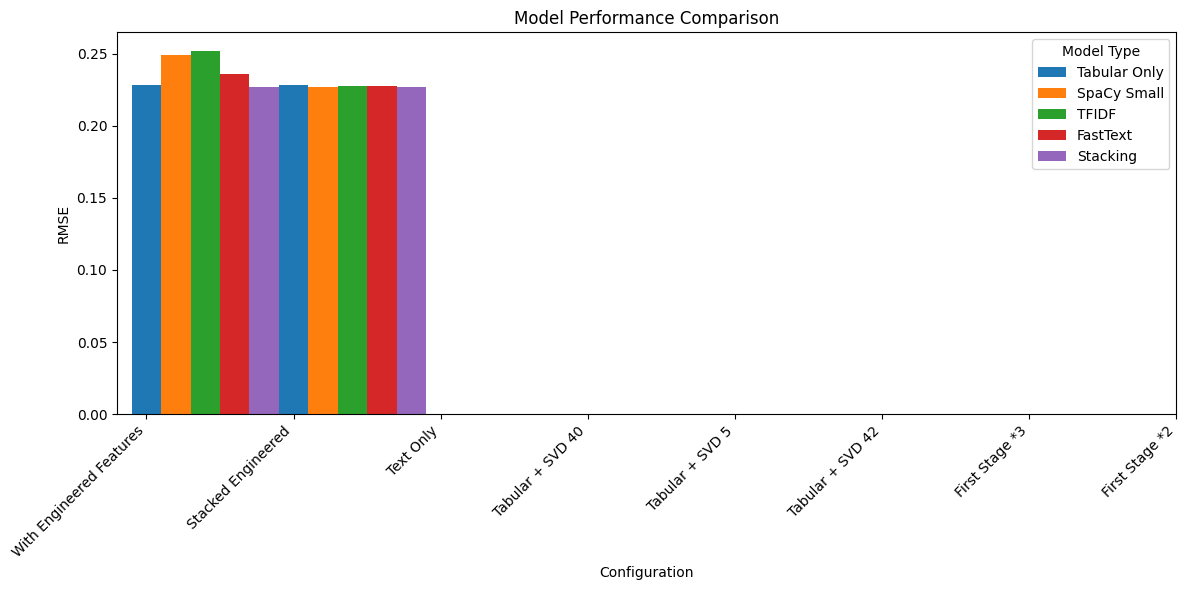

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 数据
data = {
    "Model Type": [
        "Tabular Only", "Tabular Only", "SpaCy Small", "SpaCy Small",
        "TFIDF", "TFIDF", "FastText", "FastText", "Stacking", "Stacking"
    ],
    "Configuration": [
        "With Engineered Features", "Stacked Engineered", "Text Only",
        "Tabular + SVD 40", "Text Only", "Tabular + SVD 5",
        "Text Only", "Tabular + SVD 42", "First Stage *3", "First Stage *2"
    ],
    "RMSE": [
        0.2278941776, 0.227831463997, 0.2487801457, 0.2271105849,
        0.2520660985, 0.2272839831, 0.2355021126, 0.2272785061,
        0.2269049963, 0.2271192571
    ]
}

df = pd.DataFrame(data)

# 绘图
plt.figure(figsize=(12, 6))
for i, model_type in enumerate(df["Model Type"].unique()):
    subset = df[df["Model Type"] == model_type]
    plt.bar([x + i * 0.2 for x in range(len(subset))], subset["RMSE"], width=0.2, label=model_type)

plt.xticks(range(len(df["Configuration"].unique())), df["Configuration"].unique(), rotation=45, ha="right")
plt.xlabel("Configuration")
plt.ylabel("RMSE")
plt.title("Model Performance Comparison")
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


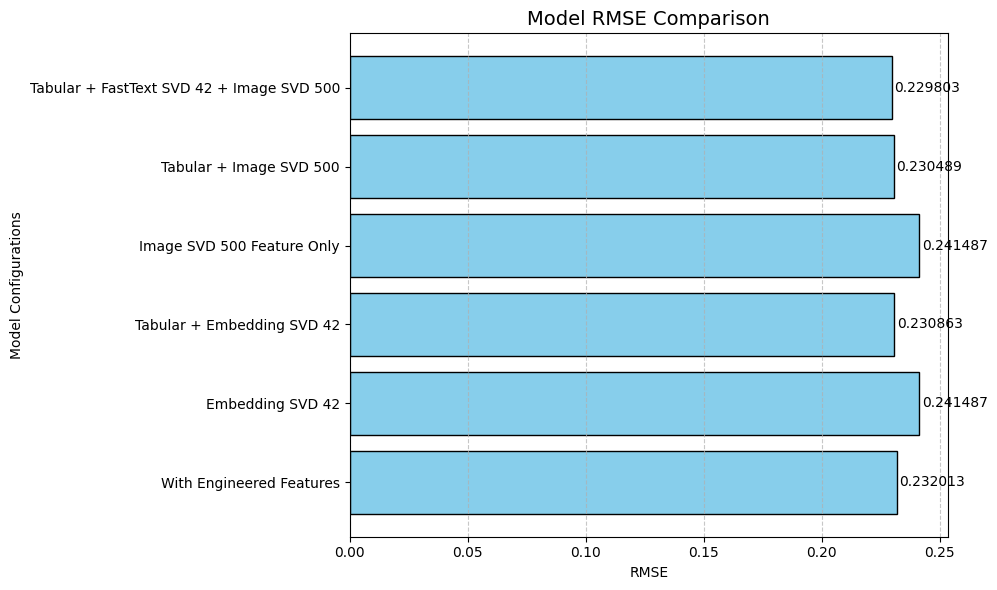

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
data = {
    "Model Type": [
        "Tabular Only",
        "FastText Embeddings\n(not pre-trained)",
        "FastText Embeddings\n(not pre-trained)",
        "Image with ResNet50",
        "Image with ResNet50",
        "Tri-modality Model"
    ],
    "Configuration": [
        "With Engineered Features",
        "Embedding SVD 42",
        "Tabular + Embedding SVD 42",
        "Image SVD 500 Feature Only",
        "Tabular + Image SVD 500",
        "Tabular + FastText SVD 42 + Image SVD 500"
    ],
    "RMSE": [
        0.232013,
        0.241487,
        0.230863,
        0.241487,
        0.230489,
        0.229803
    ]
}

df = pd.DataFrame(data)

# Create a bar chart for visualization
plt.figure(figsize=(10, 6))

# Create bars
plt.barh(df["Configuration"], df["RMSE"], color="skyblue", edgecolor="black")

# Add RMSE values to the bars
for index, value in enumerate(df["RMSE"]):
    plt.text(value + 0.001, index, f"{value:.6f}", va='center', fontsize=10)

# Set chart labels and title
plt.xlabel("RMSE")
plt.ylabel("Model Configurations")
plt.title("Model RMSE Comparison", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()
plt.show()


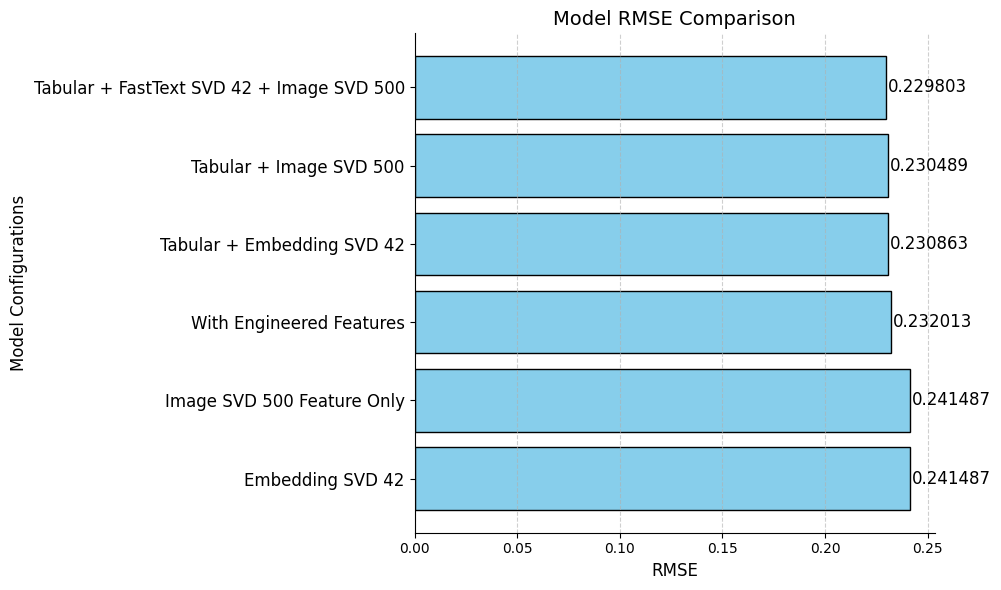

In [ ]:
# Sort the data by RMSE in descending order
df_sorted = df.sort_values(by="RMSE", ascending=False)

# Create a bar chart for the sorted data
plt.figure(figsize=(10, 6))

# Create bars
plt.barh(df_sorted["Configuration"], df_sorted["RMSE"], color="skyblue", edgecolor="black")

# Add RMSE values to the bars
for index, value in enumerate(df_sorted["RMSE"]):
    plt.text(value + 0.001, index, f"{value:.6f}", va='center', fontsize=12)

# Set chart labels and title
plt.xlabel("RMSE",fontsize=12)
plt.ylabel("Model Configurations",fontsize=12)
plt.yticks(fontsize=12)
plt.title("Model RMSE Comparison", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
# Remove outer border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# Display the chart
plt.tight_layout()
plt.show()


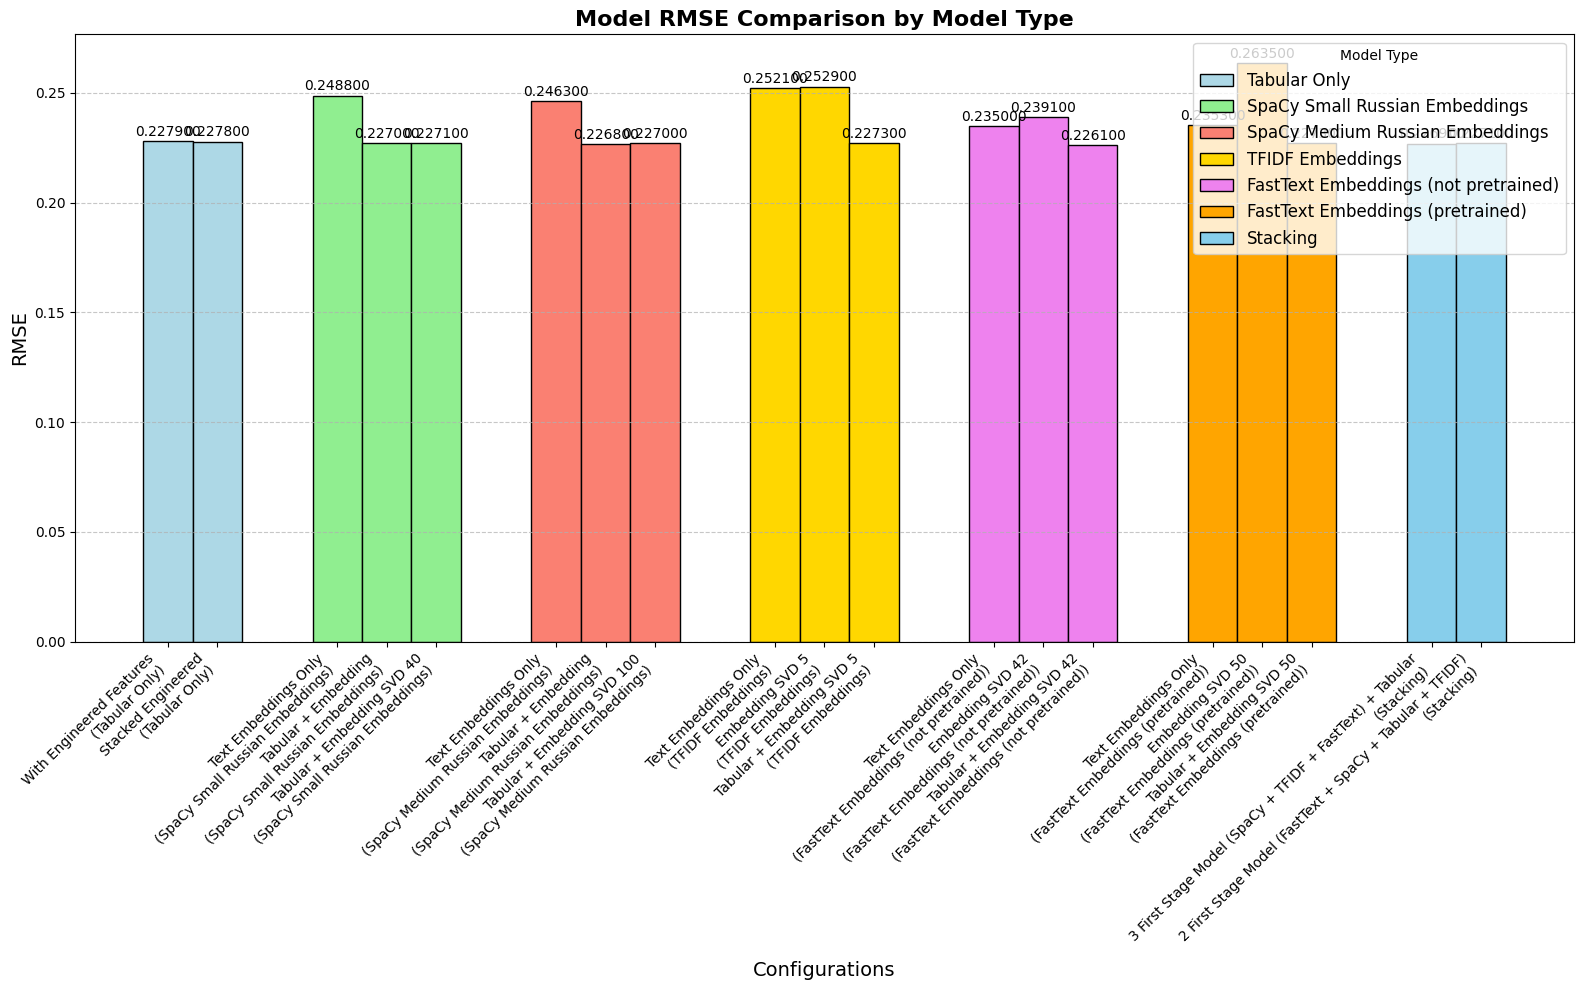

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for grouped bar chart
model_types = [
    "Tabular Only", "SpaCy Small Russian Embeddings", "SpaCy Medium Russian Embeddings",
    "TFIDF Embeddings", "FastText Embeddings (not pretrained)",
    "FastText Embeddings (pretrained)", "Stacking"
]

configurations = [
    ["With Engineered Features", "Stacked Engineered"],
    ["Text Embeddings Only", "Tabular + Embedding", "Tabular + Embedding SVD 40"],
    ["Text Embeddings Only", "Tabular + Embedding", "Tabular + Embedding SVD 100"],
    ["Text Embeddings Only", "Embedding SVD 5", "Tabular + Embedding SVD 5"],
    ["Text Embeddings Only", "Embedding SVD 42", "Tabular + Embedding SVD 42"],
    ["Text Embeddings Only", "Embedding SVD 50", "Tabular + Embedding SVD 50"],
    ["3 First Stage Model (SpaCy + TFIDF + FastText) + Tabular", "2 First Stage Model (FastText + SpaCy + Tabular + TFIDF)"]
]

rmse_values = [[0.2279, 0.2278],
 [0.2488, 0.227, 0.2271],
 [0.2463, 0.2268, 0.227],
 [0.2521, 0.2529, 0.2273],
 [0.235, 0.2391, 0.2261],
 [0.2353, 0.2635, 0.2273],
 [0.2269, 0.2271]]

# Assign distinct colors for each model type
colors = [
    "lightblue", "lightgreen", "salmon", "gold", "violet", "orange", "skyblue"
]

# Create the grouped bar chart with distinct colors
plt.figure(figsize=(16, 10))
bar_width = 0.35  # Increased bar width for better visibility
x_pos = []

current_pos = 0
for i, (model_type, config, values, color) in enumerate(zip(model_types, configurations, rmse_values, colors)):
    positions = np.arange(len(values)) * bar_width + current_pos
    x_pos.extend(positions)
    plt.bar(positions, values, bar_width, label=model_type, edgecolor="black", color=color)

    # Add RMSE values on top of the bars
    for pos, val in zip(positions, values):
        plt.text(pos, val + 0.001, f"{val:.6f}", ha='center', va='bottom', fontsize=10)  # Increased font size

    current_pos += len(values) * bar_width + 0.5  # Add gap between groups

# Adjust x-axis labels
x_labels = [f"{c}\n({m})" for m, configs in zip(model_types, configurations) for c in configs]
plt.xticks(x_pos, x_labels, fontsize=10, rotation=45, ha="right")  # Adjusted font size

# Customize chart
plt.xlabel("Configurations", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Model RMSE Comparison by Model Type", fontsize=16, weight="bold")
plt.legend(title="Model Type", fontsize=12, loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show chart
plt.tight_layout()
plt.show()


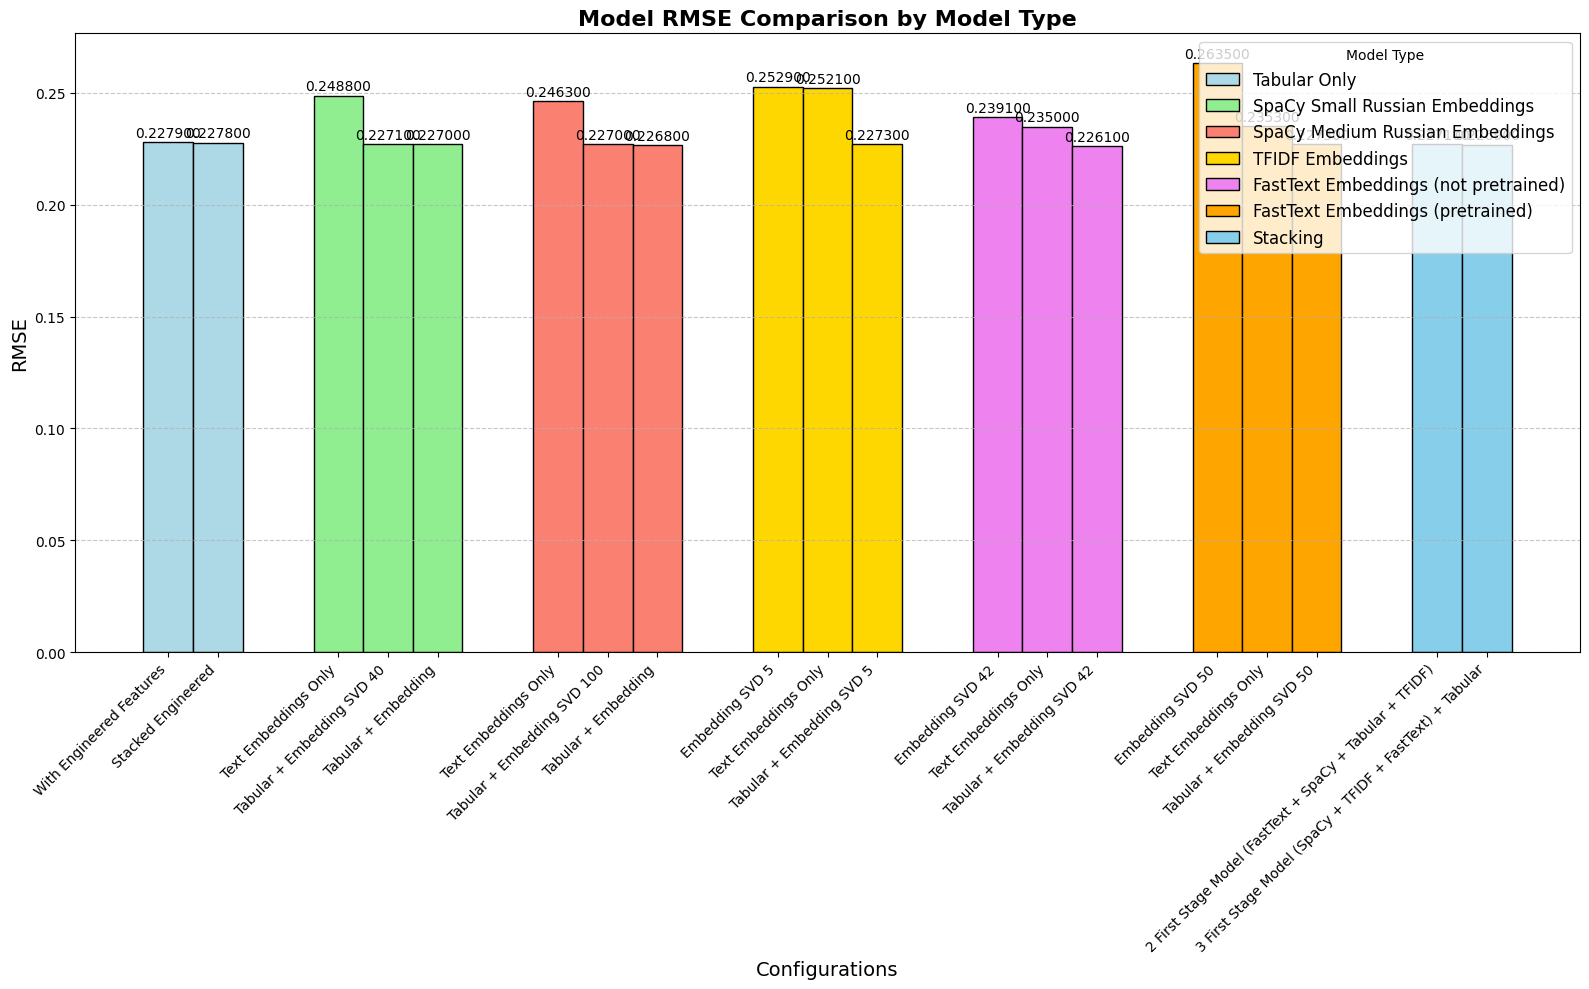

In [ ]:
# Prepare the data for grouped bar chart, sorting each group by RMSE in descending order
sorted_configurations = []
sorted_rmse_values = []

for config, values in zip(configurations, rmse_values):
    sorted_indices = np.argsort(values)[::-1]  # Sort in descending order
    sorted_configurations.append([config[i] for i in sorted_indices])
    sorted_rmse_values.append([values[i] for i in sorted_indices])

# Create the grouped bar chart
plt.figure(figsize=(16, 10))
bar_width = 0.35  # Increased bar width for better visibility
x_pos = []

current_pos = 0
for i, (model_type, config, values, color) in enumerate(zip(model_types, sorted_configurations, sorted_rmse_values, colors)):
    positions = np.arange(len(values)) * bar_width + current_pos
    x_pos.extend(positions)
    plt.bar(positions, values, bar_width, label=model_type, edgecolor="black", color=color)

    # Add RMSE values on top of the bars
    for pos, val in zip(positions, values):
        plt.text(pos, val + 0.001, f"{val:.6f}", ha='center', va='bottom', fontsize=10)  # Increased font size

    current_pos += len(values) * bar_width + 0.5  # Add gap between groups

# Adjust x-axis labels
x_labels = [f"{c}" for configs in sorted_configurations for c in configs]  # Exclude model type from labels
plt.xticks(x_pos, x_labels, fontsize=10, rotation=45, ha="right")  # Adjusted font size

# Customize chart
plt.xlabel("Configurations", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Model RMSE Comparison by Model Type", fontsize=16, weight="bold")
plt.legend(title="Model Type", fontsize=12, loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show chart
plt.tight_layout()
plt.show()


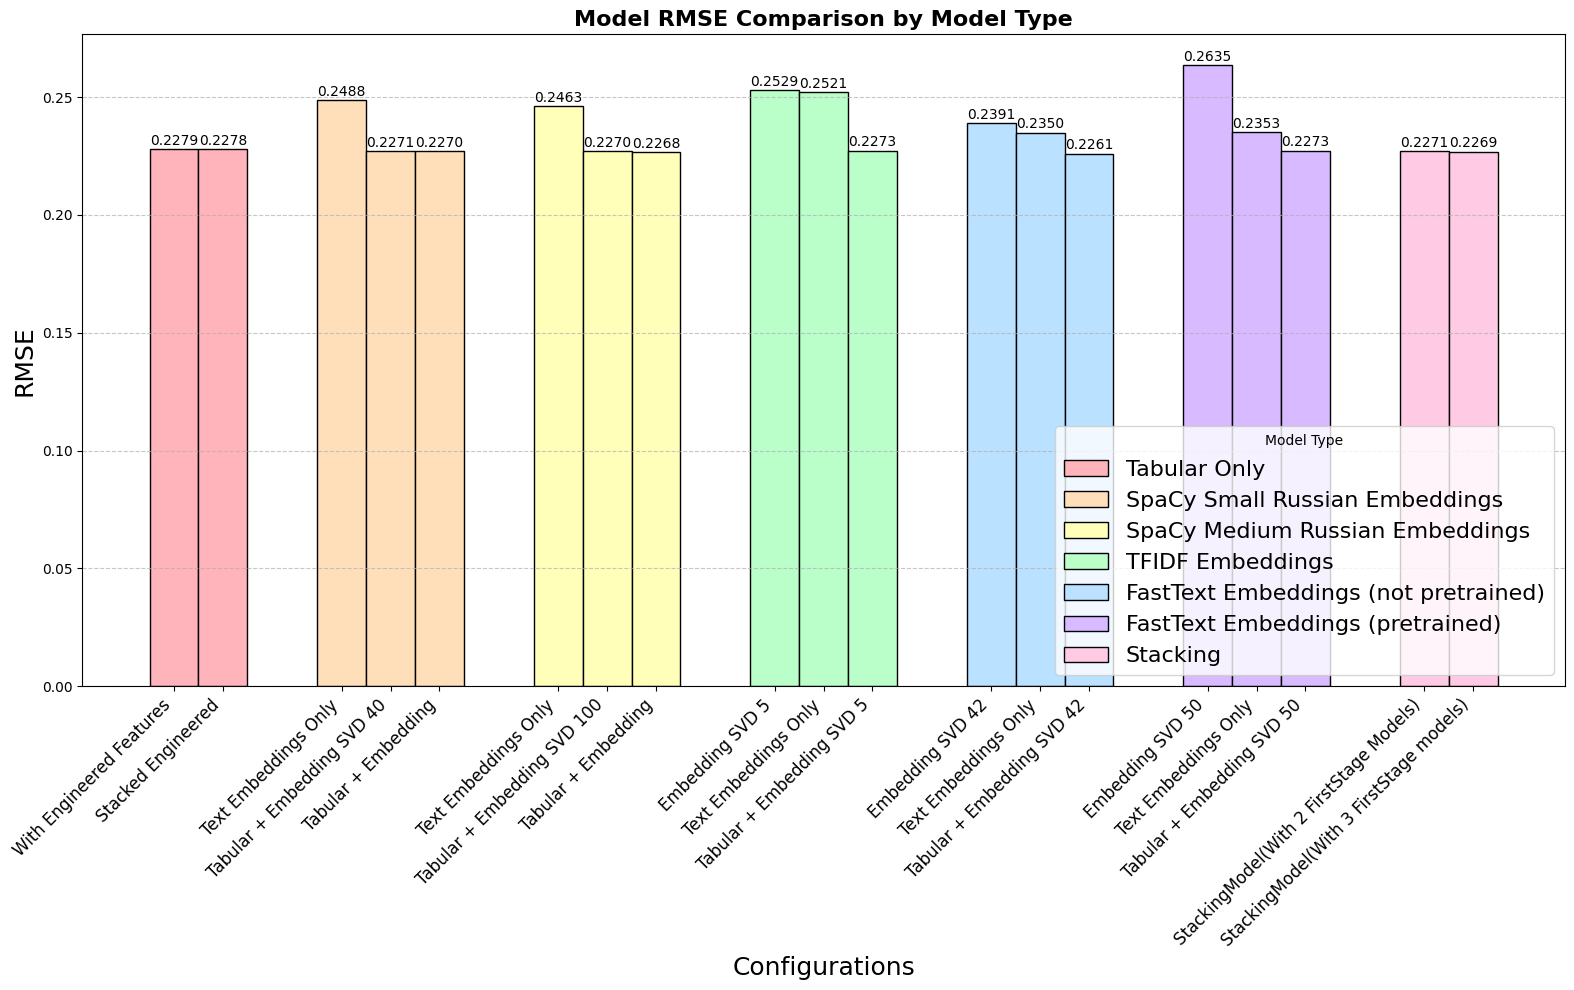

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for grouped bar chart
model_types = [
    "Tabular Only", "SpaCy Small Russian Embeddings", "SpaCy Medium Russian Embeddings",
    "TFIDF Embeddings", "FastText Embeddings (not pretrained)",
    "FastText Embeddings (pretrained)", "Stacking"
]

configurations = [
    ["With Engineered Features", "Stacked Engineered"],
    ["Text Embeddings Only", "Tabular + Embedding", "Tabular + Embedding SVD 40"],
    ["Text Embeddings Only", "Tabular + Embedding", "Tabular + Embedding SVD 100"],
    ["Text Embeddings Only", "Embedding SVD 5", "Tabular + Embedding SVD 5"],
    ["Text Embeddings Only", "Embedding SVD 42", "Tabular + Embedding SVD 42"],
    ["Text Embeddings Only", "Embedding SVD 50", "Tabular + Embedding SVD 50"],
    ["StackingModel(With 3 FirstStage models)", "StackingModel(With 2 FirstStage Models)"]
]

rmse_values = [
    [0.2279, 0.2278],
    [0.2488, 0.227, 0.2271],
    [0.2463, 0.2268, 0.227],
    [0.2521, 0.2529, 0.2273],
    [0.235, 0.2391, 0.2261],
    [0.2353, 0.2635, 0.2273],
    [0.2269, 0.2271]
]

# Assign distinct colors for each model type
colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF', '#D7BAFF', '#FFCAE4']


# Prepare the data for grouped bar chart, sorting each group by RMSE in descending order
sorted_configurations = []
sorted_rmse_values = []

for config, values in zip(configurations, rmse_values):
    sorted_indices = np.argsort(values)[::-1]  # Sort in descending order
    sorted_configurations.append([config[i] for i in sorted_indices])
    sorted_rmse_values.append([values[i] for i in sorted_indices])

# Create the grouped bar chart
plt.figure(figsize=(16, 10))
bar_width = 0.35  # Increased bar width for better visibility
x_pos = []

current_pos = 0
for i, (model_type, config, values, color) in enumerate(zip(model_types, sorted_configurations, sorted_rmse_values, colors)):
    positions = np.arange(len(values)) * bar_width + current_pos
    x_pos.extend(positions)
    plt.bar(positions, values, bar_width, label=model_type, edgecolor="black", color=color)

    # Add RMSE values on top of the bars
    for pos, val in zip(positions, values):
        plt.text(pos, val + 0.0005, f"{val:.4f}", ha='center', va='bottom', fontsize=10)  # Increased font size

    current_pos += len(values) * bar_width + 0.5  # Add gap between groups

# Adjust x-axis labels
x_labels = [f"{c}" for configs in sorted_configurations for c in configs]  # Exclude model type from labels
plt.xticks(x_pos, x_labels, fontsize=12, rotation=45, ha="right")  # Adjusted font size

# Customize chart
plt.xlabel("Configurations", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.title("Model RMSE Comparison by Model Type", fontsize=16, weight="bold")
plt.legend(title="Model Type", fontsize=16, loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show chart
plt.tight_layout()
plt.show()
